In [ ]:
#Simple nu-O event generator for 10s-of-MeV neutrinos
#Follows approach taken by NEWTON
#
#Steps:
# Supply total xs (different choices), interpolate
# Supply partial xs, fit coefficients, interpolate
# Specify neutrino flux, fold with XS, sample
# Choose excitation
# Calculate lepton energy, direction, nuclear recoil
# Draw from pre-computed TALYS de-excitation files to generate events
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd #Just for printing table of coefficients nicely
from matplotlib.colors import LogNorm
from scipy.interpolate import RegularGridInterpolator
import os
import uproot
import sys

#################
##CONFIGURATION##
#################

interpolationStep_MeV = 0.1 #Interpolate digitized plots with this precision
maxEnergy_MeV = 53
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)

total_xs_name = "data/total_xs/Haxton1987_NEWTON.csv"

partial_xs_name = "data/partial_xs/Nakazato2018.csv"

lepton_angle_name = "data/lepton_angle/Haxton1987_muDAR.csv"

deexcitation_folder = "data/nucdeex/"
if not deexcitation_folder.endswith("/"):
    deexcitation_folder+="/"

outputFormat = "ascii" #root, ascii
nps = 1000
neutrino_direction = [0,0,1]


#############
##Constants##
#############
#AME 20 mass evaluations: https://www.anl.gov/sites/www/files/2021-05/mass_1.mas20.txt
mass_16O_amu = 15994914.61926e-6 #includes 8 electrons
mass_16F_amu = 16011460.278e-6 #includes 9 electrons
amu_to_MeV = 931.49432
me_MeV = 0.51099895069
m_mu_amu = 113428.9267e-6
m_mu_MeV = m_mu_amu * amu_to_MeV
mass_16O_MeV = mass_16O_amu * amu_to_MeV
mass_16F_MeV = mass_16F_amu * amu_to_MeV

neutrino_pdg = 12
pdg_16O = 1000080160
pdg_16F = 1000090160
electron_pdg = 11

#(160 + 8 electrons) + nu_e -> (16F + 8 electrons) + 1 electron 
threshold = (mass_16F_amu-mass_16O_amu)*amu_to_MeV
print(f"Threshold of 16O CC process is {threshold:.3f} MeV")

Threshold of 16O CC process is 15.412 MeV


/var/folders/n0/5khn9c9d03746p9xsp8y4btm0000gn/T/ipykernel_8677/1965035844.py:20: RuntimeWarning: divide by zero encountered in log10
  logxs_cm2_raw = np.log10(xs_cm2_raw)


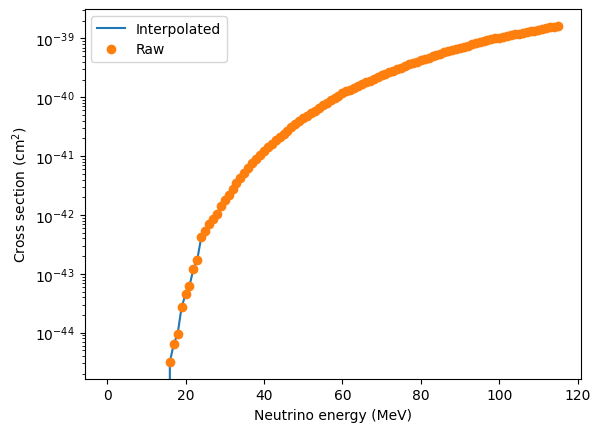

In [122]:
#################
##Load total XS##
#################
def loadCSV(fname):
  energies_MeV_raw = []
  xs_cm2_raw = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==2:
          energies_MeV_raw.append(float(lineParts[0]))
          xs_cm2_raw.append(float(lineParts[1]))
  return energies_MeV_raw,xs_cm2_raw

energies_MeV_raw,xs_cm2_raw = loadCSV(total_xs_name)

#Log-linear inteerpolation
logxs_cm2_raw = np.log10(xs_cm2_raw)
logxs_interp = np.interp(energies_MeV_interp, energies_MeV_raw, logxs_cm2_raw,left=-np.inf,right=logxs_cm2_raw[-1])
xs_cm2_interp = np.power(10,logxs_interp)

#Linear interpolation
#xs_cm2_interp = np.interp(energies_MeV_interp,energies_MeV_raw,xs_cm2_raw,left=0,right=xs_cm2_raw[-1])

########
##Plot##
########
plt.plot(energies_MeV_interp,xs_cm2_interp,label="Interpolated")
plt.plot(energies_MeV_raw,xs_cm2_raw,ls="",marker="o",label="Raw")
plt.legend()
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")


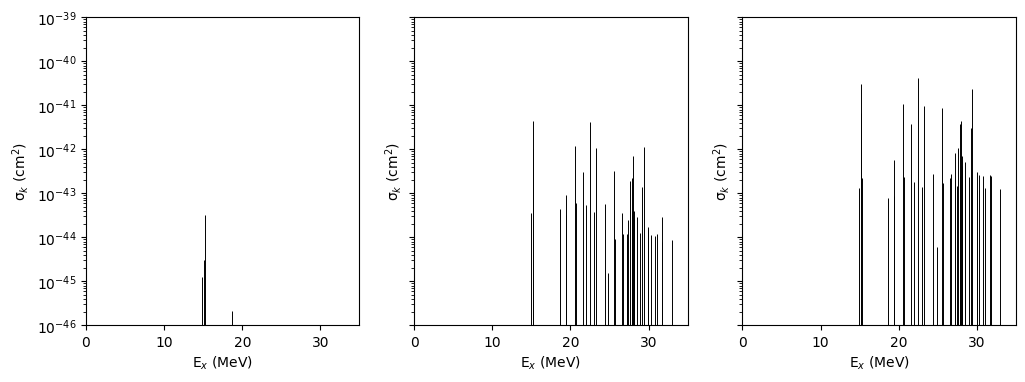

,Excited level (MeV),J,parity,20 MeV,40 MeV,60 MeV
0,14.91,0,-,1.280000e-45,3.540000e-44,1.320000e-43
1,15.16,1,-,3.100000e-45,9.960000e-43,6.810000e-42
2,15.21,2,-,3.160000e-44,4.380000e-42,3.050000e-41
3,15.25,3,-,1.000000e-46,3.800000e-45,2.250000e-43
4,18.67,1,+,2.150000e-46,4.370000e-44,8.030000e-44
5,19.42,2,-,1.000000e-47,9.180000e-44,5.820000e-43
6,19.43,1,+,1.000000e-47,3.220000e-44,8.650000e-44
7,20.57,1,-,0.000000e+00,1.220000e-42,1.090000e-41
8,20.69,1,+,0.000000e+00,5.990000e-44,2.350000e-43
9,21.62,2,-,0.000000e+00,3.040000e-43,3.700000e-42


In [123]:
#Load partial cross sections
def loadNazakatoData(fname):
  excitedLevels_MeV = []
  excitedLevels_J = []
  excitedLevels_parity = []
  excitedXS_20MeV = []
  excitedXS_40MeV = []
  excitedXS_60MeV = []
  for line in open(fname,"r"):
    if not line.startswith("#"):
      line=line.strip("\n")
      if not line=="":
        lineParts = line.split(",")
        if len(lineParts)==6:
          excitedLevels_MeV.append(float(lineParts[0]))
          excitedLevels_J.append(int(lineParts[1]))
          if lineParts[2]=="1":
            parity = "-"
          else:
            parity = "+"
          excitedLevels_parity.append(parity)
          excitedXS_20MeV.append(float(lineParts[3]))
          excitedXS_40MeV.append(float(lineParts[4]))
          excitedXS_60MeV.append(float(lineParts[5]))
  
  #FIT COEFFICIENTS
  excitedLevels_MeV = np.asarray(excitedLevels_MeV)
  excitedXS_20MeV = np.asarray(excitedXS_20MeV)
  excitedXS_40MeV = np.asarray(excitedXS_40MeV)
  excitedXS_60MeV = np.asarray(excitedXS_60MeV)

  return excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV
  
excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV = loadNazakatoData(partial_xs_name)

#Make 3 plots of xs vs. excitation energy 
fig,ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

mask = excitedXS_20MeV > 0
ax[0].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_20MeV[mask],color="k",lw=0.7)
mask = excitedXS_40MeV > 0
ax[1].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_40MeV[mask],color="k",lw=0.7)
mask = excitedXS_60MeV > 0
ax[2].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_60MeV[mask],color="k",lw=0.7)

plt.yscale("log")
ax[0].set_xlim(0,35)
ax[0].set_xlabel("E$_x$ (MeV)")
ax[0].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[0].set_ylim(1e-46,1e-39)

ax[1].set_xlim(0,35)
ax[1].set_xlabel("E$_x$ (MeV)")
ax[1].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[1].set_ylim(1e-46,1e-39)

ax[2].set_xlim(0,35)
ax[2].set_xlabel("E$_x$ (MeV)")
ax[2].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[2].set_ylim(1e-46,1e-39)
plt.show()


df = pd.DataFrame({
    "Excited level (MeV)": excitedLevels_MeV,
    "J": excitedLevels_J,
    "parity": excitedLevels_parity,
    "20 MeV": excitedXS_20MeV,
    "40 MeV": excitedXS_40MeV,
    "60 MeV": excitedXS_60MeV,
})

df

In [124]:
#Solve for coefficients
def solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV):
  c1s = []
  c2s = []
  c3s = []
  #Now step through levels, computing nu xs by fitting the three data files to determine coefficients a,b,c. Then
  for ilev,Ex in enumerate(excitedLevels_MeV):

    if Ex < 20:
      Lambda_20MeV = np.log10(np.power(20,0.25)-np.power(Ex,0.25))
    else:
      Lambda_20MeV = 0
    if Ex < 40:
      Lambda_40MeV = np.log10(np.power(40,0.25)-np.power(Ex,0.25))
    else:
      Lambda_40MeV = 0
    if Ex < 60:
      Lambda_60MeV = np.log10(np.power(60,0.25)-np.power(Ex,0.25))
    else:
      Lambda_60MeV = 0

    if excitedXS_20MeV[ilev]>1e-46:
      logxs_20MeV = np.log10(excitedXS_20MeV[ilev])
    else:
      logxs_20MeV =  -np.inf
    if excitedXS_40MeV[ilev]>0:
      logxs_40MeV = np.log10(excitedXS_40MeV[ilev])
    else:
      logxs_40MeV = -np.inf
    if excitedXS_60MeV[ilev]>0:
      logxs_60MeV = np.log10(excitedXS_60MeV[ilev])
    else:
      logxs_60MeV = -np.inf

    if logxs_20MeV==-np.inf:
      A = np.array([[1.0,Lambda_40MeV],
                  [1.0,Lambda_60MeV]])
      y = np.array([logxs_40MeV,logxs_60MeV])
      a,b = np.linalg.solve(A,y)
      c = 0
    else:
      A = np.array([[1.0,Lambda_20MeV,Lambda_20MeV*Lambda_20MeV],
                  [1.0,Lambda_40MeV,Lambda_40MeV*Lambda_40MeV],
                  [1.0,Lambda_60MeV,Lambda_60MeV*Lambda_60MeV]])
      y = np.array([logxs_20MeV,logxs_40MeV,logxs_60MeV])
      a,b,c = np.linalg.solve(A,y)

    c1s.append(a)
    c2s.append(b)
    c3s.append(c)

  return c1s,c2s,c3s
  
c1s,c2s,c3s = solveCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV)

df = pd.DataFrame({
    "Excited level (MeV)": excitedLevels_MeV,
    "a": c1s,
    "b": c2s,
    "c": c3s,
})

df
      


,Excited level (MeV),a,b,c
0,14.91,-42.567378,3.669191,1.030182
1,15.16,-40.714086,5.003411,0.629842
2,15.21,-40.033353,5.359914,1.523212
3,15.25,-41.707498,10.098327,0.000000
4,18.67,-42.938851,0.926599,-0.668530
5,19.42,-41.623240,3.708173,0.000000
6,19.43,-42.735442,1.983075,0.000000
7,20.57,-40.197107,4.143248,0.000000
8,20.69,-42.148820,2.569987,0.000000
9,21.62,-40.524354,4.473532,0.000000


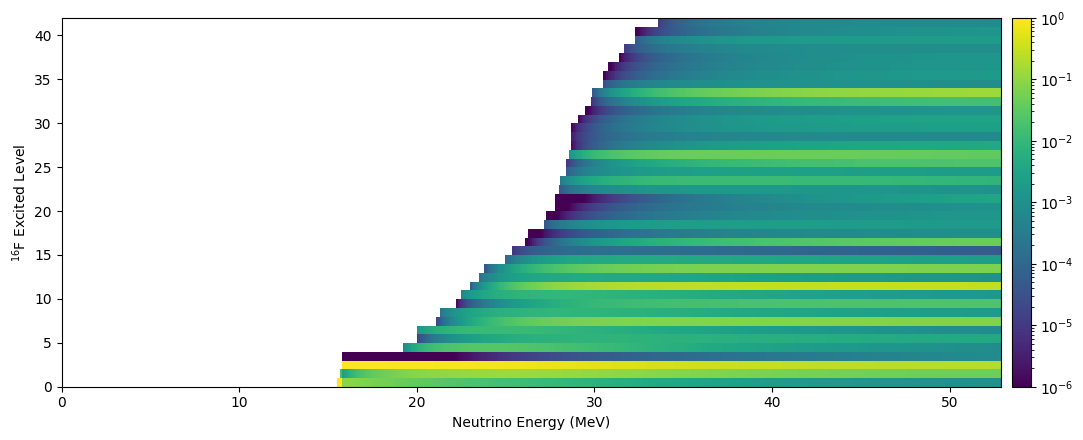

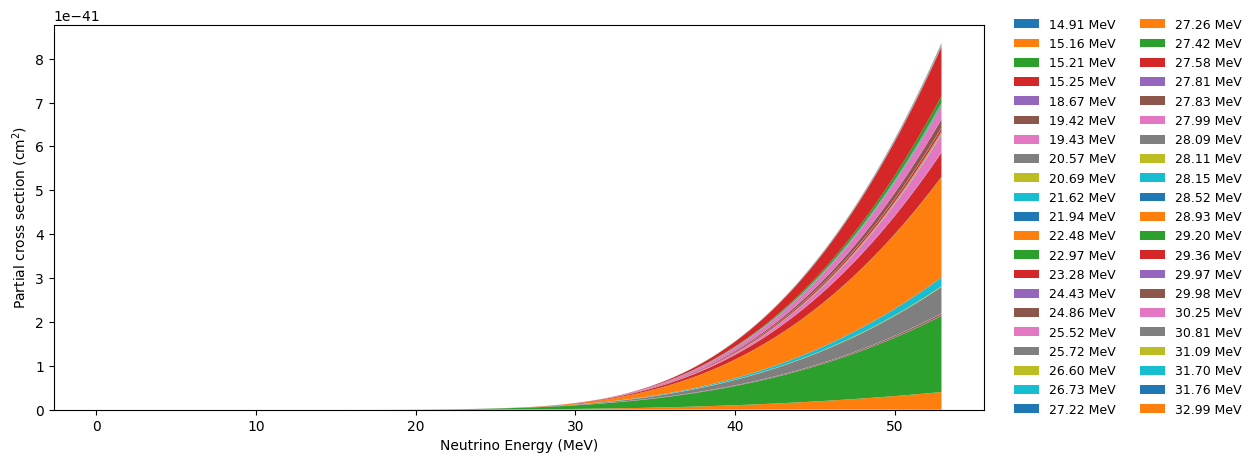

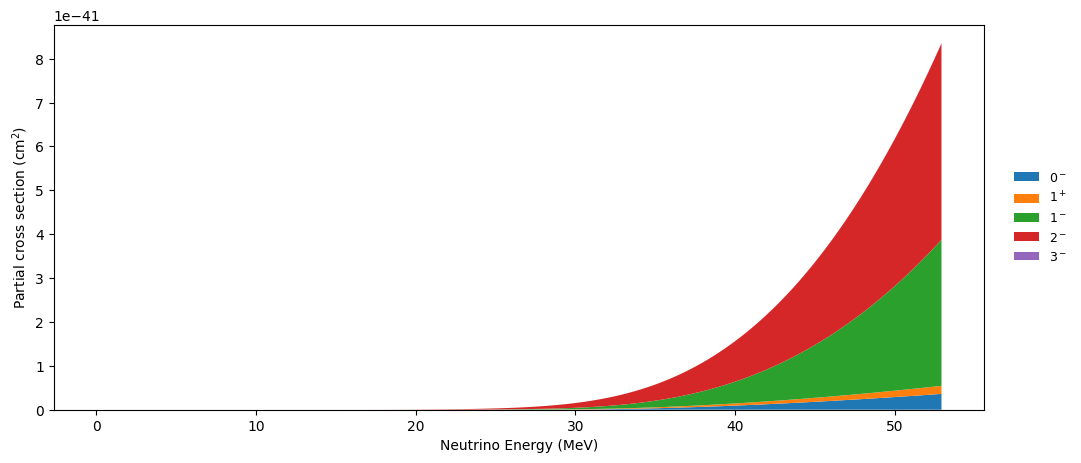

In [125]:
#Now calculate partial_xs
eps_MeV = 0.0

partial_xs = []
for ilev,Ex_MeV in enumerate(excitedLevels_MeV):
  xs = np.zeros_like(energies_MeV_interp)
  if c3s[ilev]==0:
    for inrg,E in enumerate(energies_MeV_interp):
      if E<=Ex_MeV + me_MeV:
        continue
      Lam = np.log10(np.power(E,0.25)-np.power(Ex_MeV,0.25))
      log10XS = c1s[ilev] + c2s[ilev]*Lam
      xs[inrg] = np.power(10,log10XS)
  else:
    for inrg,E in enumerate(energies_MeV_interp):
      if E<=Ex_MeV + me_MeV:
        continue
      Lam = np.log10(np.power(E,0.25)-np.power(Ex_MeV,0.25))
      log10XS = c1s[ilev] + c2s[ilev]*Lam + c3s[ilev]*Lam*Lam
      xs[inrg] = np.power(10,log10XS)
  
  partial_xs.append(xs)


#############################
##Compare with Baran's plot##
#############################
Z = np.vstack([np.asarray(xs) for xs in partial_xs])
#Convert to probabilities
colsum = Z.sum(axis=0)                                
excitation_probs = np.zeros_like(Z, dtype=float)
nonzero_mask = colsum > 0
excitation_probs[:, nonzero_mask] = Z[:, nonzero_mask] / colsum[nonzero_mask]

# Plot: y-axis is uniform "level index" bins; labels show actual excited levels (optional)
fig, ax = plt.subplots(figsize=(12, 4.5))

im = ax.imshow(
    excitation_probs,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
    norm=LogNorm(vmin=1e-6, vmax=1.0),
    extent=[energies_MeV_interp[0],
            energies_MeV_interp[-1],
            0,
            excitation_probs.shape[0]]
)

ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel("$^{16}$F Excited Level")
cbar = plt.colorbar(im, ax=ax, pad=0.01)
plt.tight_layout()

#####################
##Plot exclusive xs##
#####################
fig2,ax2 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in partial_xs])   # (nlev, nE)

labels = [f"{excitedLevels_MeV[i]:.2f} MeV" for i in range(xs_stack.shape[0])]

ax2.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(r"Partial cross section (cm$^2$)")
ax2.set_yscale("linear")

ax2.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    ncol=2,                      # number of columns (adjust as needed)
    fontsize=9,
    frameon=False
)

##################
##Multipole plot##
##################
JPis = np.array([f"{J}$^{p}$"
                 for J, p in zip(excitedLevels_J, excitedLevels_parity)])
multipoles = np.unique(JPis)
multipole_xs=[np.zeros_like(energies_MeV_interp) for _ in multipoles]
for mi, multipole in enumerate(multipoles):
    indices = np.where(JPis == multipole)[0]
    for idx in indices:
        multipole_xs[mi] += partial_xs[idx]    # <-- add into the right bucket


fig3,ax3 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in multipole_xs])   # (nMultipoles, nE)
labels = list(multipoles)

ax3.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax3.set_xlabel("Neutrino Energy (MeV)")
ax3.set_ylabel(r"Partial cross section (cm$^2$)")
ax3.set_yscale("linear")

ax3.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    fontsize=9,
    frameon=False
)

plt.show()

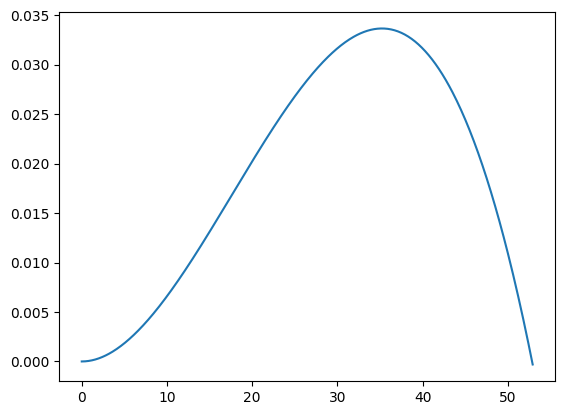

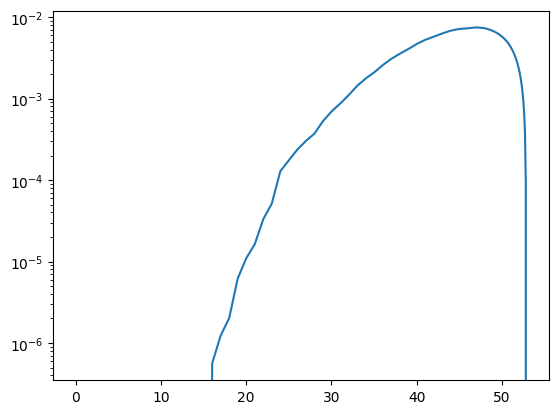

In [126]:
#SNS neutrino spectrum
fig,ax=plt.subplots()
dar_spectrum = 96*np.power(energies_MeV_interp,2) * np.power(m_mu_MeV,-4)  * (m_mu_MeV - 2*energies_MeV_interp)
plt.plot(energies_MeV_interp,dar_spectrum)

fig2,ax2=plt.subplots()
folded_spectrum = np.multiply(xs_cm2_interp,dar_spectrum)
fs = np.where(folded_spectrum > 0, folded_spectrum, 0.0)
neutrino_energy_probs = fs / fs.sum()
plt.plot(energies_MeV_interp,neutrino_energy_probs)
plt.yscale("log")

flux_averaged_xs = np.average(folded_spectrum)
flux_averaged_xs_naturalunits = flux_averaged_xs/(3.89379290*np.power(10.,-22))

plt.show()

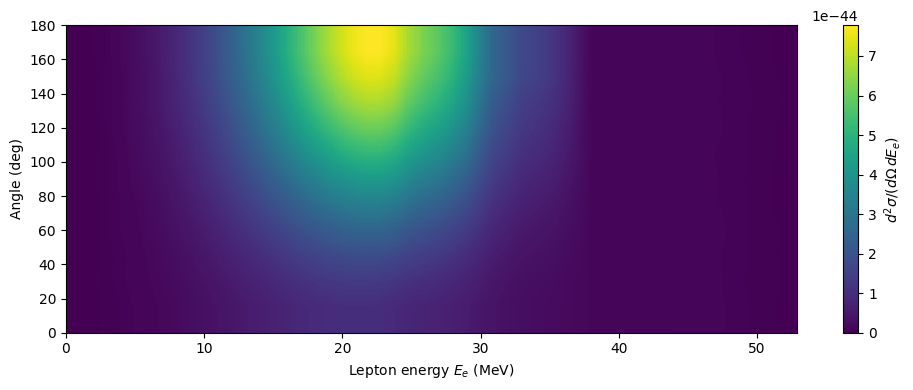

In [127]:
#Load up lepton angular distributions
degrees = [15.,30.,45.,60.,75.,90.,105.,120.,135.,150.,165.]

def loadHaxtonCSV(fname):
  lepton_energies_raw = [[] for _ in degrees]
  lepton_xs_raw       = [[] for _ in degrees]
  
  for line in open(lepton_angle_name,"r"):
    if line.startswith("#"):
      continue
    line=line.strip("\n")
    if not line=="":
      lineParts = line.split(",")

      for i in range(len(degrees)):
        lepton_energy_str  = lineParts[2*i]
        lepton_xs_str =  lineParts[2*i + 1]

        if lepton_energy_str != "":
          lepton_energies_raw[i].append(float(lepton_energy_str))
          lepton_xs_raw[i].append(float(lepton_xs_str))

  return lepton_energies_raw,lepton_xs_raw

lepton_energies_raw,lepton_xs_raw = loadHaxtonCSV(lepton_angle_name)

#Use 15 deg dist for 0, 165 deg dist for 180
degrees.insert(0,0.)
lepton_energies_raw.insert(0,list(lepton_energies_raw[0]))
lepton_xs_raw.insert(0,list(lepton_xs_raw[0]))
degrees.append(180.)
lepton_energies_raw.append(list(lepton_energies_raw[-1]))
lepton_xs_raw.append(list(lepton_xs_raw[-1]))

#Interpolate lepton energies
angles_interp= np.linspace(0,180,180)
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)
lepton_xs_interp = []
for ideg,deg in enumerate(degrees):
  lepton_xs_interp.append(np.interp(energies_MeV_interp,lepton_energies_raw[ideg],lepton_xs_raw[ideg],left=0,right=0))

#For interpolator for interpolating angles
lepton_xs_interp = np.array(lepton_xs_interp)
grid_interp = RegularGridInterpolator(
    (np.array(degrees), energies_MeV_interp),
    lepton_xs_interp,
    bounds_error=False,
    fill_value=0.0   # for energy outside range
)

#Interpolate
A, E = np.meshgrid(angles_interp, energies_MeV_interp, indexing="ij")
pts = np.stack([A.ravel(), E.ravel()], axis=-1)
angular_xs_cm2 = grid_interp(pts, method="linear").reshape(len(angles_interp), len(energies_MeV_interp))

#Plot
fig, ax = plt.subplots(figsize=(10,4))

im = ax.imshow(
    angular_xs_cm2,
    origin="lower",
    aspect="auto",
    extent=[energies_MeV_interp[0], energies_MeV_interp[-1],
            angles_interp[0], angles_interp[-1]],
    interpolation="None"
)

ax.set_xlabel("Lepton energy $E_e$ (MeV)")
ax.set_ylabel("Angle (deg)")
cb = fig.colorbar(im, ax=ax)
cb.set_label(r"$d^2\sigma/(d\Omega\, dE_e)$")

fig.tight_layout()

plt.show()

##Normalize
colsum = angular_xs_cm2.sum(axis=0)

lepton_angle_probs = np.zeros_like(angular_xs_cm2)
mask = colsum > 0
lepton_angle_probs[:, mask] = angular_xs_cm2[:, mask] / colsum[mask]



In [128]:
#Load NucDeEx trees into memory ~500MB root files total
ex_filenames = [i for i in os.listdir(deexcitation_folder) if i.endswith(".root")]
ex_filenames.sort()
ex_levels = [round(float(i.split("_")[1]),2) for i in ex_filenames]
ex_levels.insert(0,0)
ex_dfs = [None]

for fname in ex_filenames:
    fpath = deexcitation_folder+fname
    with uproot.open(fpath) as f:
        # If there's only one TTree in the file
        tree = f["tree"]

        # Load all branches into a DataFrame
        df = tree.arrays(library="pd")

    ex_dfs.append(df)

In [ ]:
def calcMomentum(E, m, direction):
    direction = np.asarray(direction, dtype=float)
    direction_hat = direction / np.linalg.norm(direction)

    p = np.sqrt(E**2 - m**2)

    px, py, pz = p * direction_hat
    return px, py, pz

#Use energy and momentum conservation to solve for the lepton energy, nuclear recoil energy, and nuclear recoil direction
#given the neutrino energy, angle between neutrino and lepton, and excitation energy passed to the nucleus
def calcKinematics(E_nu,theta_rad,Ex):
    M_tar = mass_16O_MeV
    M_res = mass_16F_MeV
    M_lep = me_MeV
    #Energy conservation:
    #E_nu + M_tar = E_lep + E_res
    #with E_res = sqrt(k_res^2 + (M_res + Ex)^2)
    #Rearrange
    #E_nu + M_tar - E_lep = sqrt(k_res^2 + (M_res + Ex)^2)
    #Square both sides
    #(E_nu + M_tar - E_lep)^2 = k_res^2 + (M_res + Ex)^2
    #Solve for k_res^2
    #k_res^2 = (E_nu + M_tar - E_lep)^2 - (M_res + Ex)^2
    #To simplify, define
    var1 = E_nu + M_tar
    var2 = np.power(M_res + Ex,2)
    #k_res^2 = (var1 - E_lep)^2 - var2

    #Momentum conservation
    #k_nu = k_lep + k_res
    #rearranging
    #k_res = k_nu - k_lep
    #Calculate the magnitude
    #k_res^2 = k_nu^2 + k_lep^2 - 2*k_nu*k_lep*cos(theta)
    #Plug in k_res^2
    #(var1 - E_lep)^2 - var2 = k_nu^2 + k_lep^2 - 2*k_nu*k_lep*cos(theta)
    #But k_lep is defined as
    #k_lep = sqrt(E_lep^2 - m_lep^2)
    #and
    #|k_nu| = |E_nu|
    #So
    #(var_1 - E_lep)^2 - var2 = E_nu^2 + E_lep^2 - m_lep^2 - 2 * E_nu * sqrt(E_lep^2 - m_lep^2)*cos(theta)
    #simplify
    var3 = np.power(E_nu,2) - np.power(M_lep,2)
    var4 = 2 * E_nu * np.cos(theta_rad)
    #to get
    #(var1 - E_lep)^2 - var2 = var3 + E_lep^2 - var4*sqrt(E_lep^2 - m_lep^2)
    #Isolate sqrt
    #var4 * sqrt(E_lep^2 - m_lep^2) = var3 + E_lep^2 + var2 - (var1 - E_lep)^2 
    #                               = var3 + var2 - var1^2 + E_lep^2 - E_lep^2 + 2*var1*E_lep
    #                               = var3 + var2 - var1^2 + 2*var1*E_lep
    #sqrt(E_lep^2 - m_lep^2) = (var3 + var2 - var1^2 + 2*var1*E_lep)/var4
    #Simplifying
    #sqrt(E_lep^2 - m_lep^2) = (var3 + var2 - var1^2)/var4 + 2*var1*E_lep/var4
    #and then defining
    var5 = (var3 + var2 - np.power(var1,2))/var4
    var6 = 2*var1/var4
    #We get
    #sqrt(E_lep^2 - m_lep^2) = var5 + var6*E_lep #CONDITION TO CHECK AT THE END
    #Squaring
    #E_lep^2 - m_lep^2 = var5^2 + var6^2*E_lep^2 + 2*var5*var6*E_lep 
    #Group
    #E_lep^2(1-var6^2) - 2*var5*var6*E_lep - var5^2 - m_lep^2 = 0
    A = 1-np.power(var6,2)
    B = -2*var5*var6
    C = - np.power(var5,2) - np.power(M_lep,2)
    #Quadratic formulate
    if B*B < 4*A*C:
        print("ERROR!")
        print(B*B,4*A*C)
        sys.exit()
    
    E_lep_1 = (-B + np.sqrt(B*B - 4*A*C)) / (2*A)
    E_lep_2 = (-B - np.sqrt(B*B - 4*A*C)) / (2*A)

    #Check for validity
    sol1_is_valid = False
    sol2_is_valid = False
    if E_lep_1 > M_lep and var5 + var6*E_lep_1 > 0:
        sol1_is_valid=True
    if E_lep_2 > M_lep and var5 + var6*E_lep_2 > 0:
        sol2_is_valid=True

    if sol1_is_valid and sol2_is_valid:
        print(E_lep_1,E_lep_2)
        sys.exit()
    elif sol1_is_valid:
        E_lep = E_lep_1
    elif sol2_is_valid:
        E_lep = E_lep_2
    else:
        print("No sol is valid")
        sys.exit()

    # Calculate energy of the residual system
    E_res = (E_nu + mass_16O_MeV) - E_lep
    #Calculate momentum of the residual system
    # k_res^2 = E_res^2 - M_eff^2
    k_res_2 = np.power(var1 - E_lep,2) - var2
    #k_res_mag = np.sqrt(max(0, k_res_2)) #Floating point precision catch
    k_res_mag = np.sqrt(k_res_2)

    return E_lep, E_res, k_res_mag
    
 

    

In [ ]:
#Generate our events
line=str(flux_averaged_xs_naturalunits)
Ni = 2 #Hardcoded

#Sample neutrino eneries from folded xs times spectrum
sampled_neutrino_energies_MeV = np.random.choice(energies_MeV_interp, size=nps, p=neutrino_energy_probs)
#Get the indices on our sampled energy grid
sampled_energy_indices = np.searchsorted(energies_MeV_interp, sampled_neutrino_energies_MeV)

#Sample our excitation probabilities at the neutrino energy, calculate lepton energy, angle
for Enu_idx in sampled_energy_indices:
  #Sample excitation state index
  ex_idx = np.random.choice([i for i in range(0,len(excitedLevels_MeV))],size=1,p=excitation_probs[:, Enu_idx])[0]

  # get the excitation energy, twoJ, parity
  event_excitation_energy_MeV = round(excitedLevels_MeV[ex_idx] - 14.91,2)
  event_excitation_twoJ = int(2*excitedLevels_J[ex_idx])
  event_excitation_parity = excitedLevels_parity[ex_idx]

  #Sample NucDeEx deexcitation
  nOutputParticles=0
  if not ex_idx==0:
    sampled_deex_idx = np.random.randint(0, len(ex_dfs[ex_idx]))
    event_deex = ex_dfs[ex_idx].iloc[sampled_deex_idx]
    if not event_excitation_energy_MeV==event_deex.Ex_MeV:
      print("Error sampling deex files!")
      print(ex_idx,event_deex.Ex_MeV,event_excitation_energy_MeV)
      sys.exit()
    nOutputParticles = event_deex.size
  
  #Generate output line summary
  Nf = int(2 + nOutputParticles)
  line += f"\n{Ni} {Nf} {event_excitation_energy_MeV:.17e} {event_excitation_twoJ} {event_excitation_parity}"
  
  #Generate input particles line
  #Neutrino
  Enu = energies_MeV_interp[Enu_idx]
  PXnu,PYnu,PZnu = calcMomentum(Enu,0,neutrino_direction)
  p_nu_vec = np.array([PXnu, PYnu, PZnu])
  line += f"\n{neutrino_pdg} {Enu:.17e} {PXnu:.17e} {PYnu:.17e} {PZnu:.17e} {0:.17e} {0}"
  #Nucleus
  line += f"\n{pdg_16O} {mass_16O_MeV:.17e} {0:.17e} {0:.17e} {0:.17e} {mass_16O_MeV:.17e} {0}"

  #Calculate lepton kinematics, residual recoil
  #Sample lepton energy (get approximate value)
  Ee_sampled = energies_MeV_interp[Enu_idx] - event_excitation_energy_MeV
  Ee_idx = np.searchsorted(energies_MeV_interp,Ee_sampled)
  #Use approximate lepton energy to sample lepton angle
  event_lepton_theta_deg = np.random.choice(angles_interp,p=lepton_angle_probs[:,Ee_idx])
  event_lepton_theta_rad = event_lepton_theta_deg*np.pi/180.
  event_lepton_phi_rad = 2*np.pi*np.random.random()
  event_lepton_direction = [np.sin(event_lepton_theta_rad)*np.cos(event_lepton_phi_rad),
                            np.sin(event_lepton_theta_rad)*np.sin(event_lepton_phi_rad),
                            np.cos(event_lepton_theta_rad)]
  event_lepton_phi_rad = 2 * np.pi * np.random.random()

  #Calculate lepton energy, residual total energy, residual momentum, ensuring energy and momentum are conserved
  Ee_MeV,Eres_MeV,k_res_mag = calcKinematics(Enu, event_lepton_theta_rad, event_excitation_energy_MeV)

  #Generate output particles #TODO: rotate based on neutrino direction
  #Lepton
  #p_lep_mag = np.sqrt(max(0, Ee_MeV**2 - me_MeV**2))
  p_lep_mag = np.sqrt(np.power(Ee_MeV,2) - np.power(me_MeV,2))
  PXe = p_lep_mag * np.sin(event_lepton_theta_rad) * np.cos(event_lepton_phi_rad)
  PYe = p_lep_mag * np.sin(event_lepton_theta_rad) * np.sin(event_lepton_phi_rad)
  PZe = p_lep_mag * np.cos(event_lepton_theta_rad)
  line += f"\n{electron_pdg} {Ee_MeV:.17e} {PXe:.17e} {PYe:.17e} {PZe:.17e} {me_MeV:.17e} {-1}"

  # 4. Determine Nuclear Recoil Vector (Conservation: p_nu = p_lep + p_res)
  PXres = -PXe
  PYres = -PYe
  PZres = Enu - PZe

  # 5. Define Boost Vector (beta = p/E)
  beta_vec = np.array([PXres, PYres, PZres]) / Eres_MeV
  beta_mag2 = np.dot(beta_vec, beta_vec)
  gamma = 1.0 / np.sqrt(max(1e-12, 1.0 - beta_mag2))

  # 6. Process De-excitation Products
  if ex_idx == 0:
      # Ground state: Output the 16F nucleus recoil
      line += f"\n{pdg_16F} {Eres_MeV:.17e} {PXres:.17e} {PYres:.17e} {PZres:.17e} {mass_16F_MeV:.17e} {1}"
  else:
      # Boost each precomputed particle from the rest frame to the lab frame
      for i in range(nOutputParticles):
          pdg_i  = int(event_deex['PDG'][i])
          m_i    = event_deex['mass_MeV'][i]
          E_rest = event_deex['totalE_MeV'][i]
          p_rest = np.array([
              event_deex['PX_MeV'][i],
              event_deex['PY_MeV'][i],
              event_deex['PZ_MeV'][i]
          ])

          # Lorentz Boost: E_lab = gamma * (E_rest + beta . p_rest)
          E_lab = gamma * (E_rest + np.dot(beta_vec, p_rest))
          
          # p_lab = p_rest + [((gamma-1)(p_rest.beta)/beta^2) + gamma*E_rest] * beta
          if beta_mag2 > 1e-15:
              p_lab = p_rest + ((gamma - 1) * np.dot(p_rest, beta_vec) / beta_mag2 + gamma * E_rest) * beta_vec
          else:
              p_lab = p_rest

          line += f"\n{pdg_i} {E_lab:.17e} {p_lab[0]:.17e} {p_lab[1]:.17e} {p_lab[2]:.17e} {m_i:.17e} {1}"
    #Boost de-excitation produce

print(line)
    

  #Write ascii output 

27.87707332733343
32.28865386945749
22.66231460773932
12.633394409216194
22.02903309388353
29.816915523487715
28.72366957542461
20.143461971683415
27.127235509905642
12.61377051399364
22.181812429124044
18.09218698831245
26.042974504674916
11.872666623871416
28.206037810290976
35.388344490713344
18.756736376827337
14.698284715573605
26.732640241099148
16.020015321007705
25.75106151229447
21.407829065000406
22.27563843691822
21.656886662451065
22.565239118564524
30.276828751251635
20.820396658697867
24.598872469290416
30.05554219975674
15.069142813436732
20.313470816129342
20.662467367289494
22.113891608147206
17.302681532397443
34.10413993258006
20.990542599172564
25.461072753814346
32.609151821592604
20.234342468825385
25.76399191241771
20.277200160242636
19.395240734721856
9.02430751649836
24.556556363300338
19.06965340101511
19.605124446080207
12.375763491341077
12.74815390930681
23.769844429628183
31.938391221996604
27.32917585433471
24.80763969675881
12.765400880670388
22.26817913